# Ensemble Evaluation: Timepoint 1 - Spring 2020

Location: New York State

Timepoint 1: April 3, 2020. Setting: New York State at the beginning of the pandemic when masking was the main preventative measure. No vaccines available. 

Using case and death data for calibration (hospitalization data not available for this timepoint). No vaccination, no variants, and reinfection is not considered.

T1 28-day forecasts:

## Set up for ensemble modeling

### Load dependencies
Import functionality from the pyciemss library to allow for model sampling and calibration.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyciemss.Ensemble.interfaces import (
    load_and_sample_petri_ensemble, load_and_calibrate_and_sample_ensemble_model
)
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_and_optimize_and_sample_petri_model,
    load_and_calibrate_and_optimize_and_sample_petri_model
)
from pyciemss.visuals import plots
from pyciemss.utils import get_tspan
from pyciemss.utils.interface_utils import cdc_reformatcsv

### Collect relevant models
<!-- We have chosen x number of models to capture the relevant COVID-19 dynamics for this setting. 
 - `model1` contains compartments SEIRHD, and is stratified by age into four groups.
 - `model2` is the same as `model1`, but allows for reinfection
 - `model3` is the same as `model1`, but with a variation in transmission rate to account for masking efficacy and compliance. -->

In [2]:
# model1_location = "../../notebook/ensemble_eval_sa/operative_models/SEIRHD_base_model_ee.json"
model2_location = "../../notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_ee.json"
# model3_location = "../../notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_beta_c_varying_ee.json"
# model4_location = "../../notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_k_varying_ee.json"
# model5_location = "../../notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_age_stratified_v1.json"
model6_location = "../../notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_age_stratified_v2.json"
model7_location = "../../notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_age_stratified_v3.json"
# model8_location = "../../notebook/ensemble_eval_sa/operative_models/SEIRD_ymo_age_strat.json"

### Gather data, and set training and forecast intervals
For this timepoint, only case and death data is available for calibration. 

We take the total population of New York State to be 19,340,000. Population age-structure estimates for New York State were taken (and scaled appropriately) from [here](https://www.health.ny.gov/statistics/vital_statistics/2016/table01.htm).

First recorded case in New York State: March 1, 2020.

Also relevant is that a statewide stay-at-home order for non-essential workers was implemented on March 22, 2020, and masking policy was implemented on April 15, 2020. A nice list of COVID-19 policy interventions for New York City and State has been compiled [here](https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986![image.png](attachment:d380d245-11ca-41f1-9863-e2a2dcf5ebce.png)![image.png](attachment:b30f6e31-bc7f-43a8-b7c8-b1df78db3b86.png)![image.png](attachment:b5109588-59ed-447c-9271-50eb56fe9081.png)![image.png](attachment:2c42138a-696d-4cef-9b79-4843d38ff029.png)).

### Define a function to process the source data and produce the necessary datasets for plotting and calibration

In [3]:
def data_selector_function(data_df, train_start_row_num, train_end_row_num, forecast_end_row_num):
    '''
    This function produces three datasets: all_data, test_data, train_data.
    '''
    all_data = data_df[train_start_row_num:forecast_end_row_num].reset_index()
    all_data = all_data.drop(columns="timestep")
    all_data = all_data.drop(columns="index")

    test_data = data_df[train_end_row_num:forecast_end_row_num].reset_index()
    test_data = test_data.drop(columns="timestep")
    test_data = test_data.drop(columns="index")

    train_data = data_df[train_start_row_num:train_end_row_num].reset_index(drop=True)
    train_data1 = train_data.assign(timepoints=[float(i) for i in range(len(train_data))])
    train_data = train_data1[["timepoints", "I", "H", "D"]]

    num_timepoints = (len(train_data) + len(test_data))*10 + 1
    simulation_timepoints = list(get_tspan(0, (len(train_data) + len(test_data)), num_timepoints).detach().numpy())
    
    return all_data, test_data, train_data, simulation_timepoints

### Gather source data and set `DATA_PATH`

In [4]:
url = 'https://raw.githubusercontent.com/DARPA-ASKEM/experiments/main/thin-thread-examples/milestone_12month/evaluation/ensemble_eval_SA/datasets/aabb3684-a7ea-4f60-98f1-a8e673ad6df5/dataset.csv'
nys_data = pd.read_csv(url)
DATA_PATH = "../../notebook/ensemble_eval_sa/datasets/"

### Create and save datasets and simulation timepoints for each forecast

In [5]:
### Forecast 1: 04/03/2020 - 05/01/2020, data: 03/01/2020 - 04/02/2020

# Forecast 1: 04/03/2020 (day 32, row 73) - 05/01/2020 (day 60, row 101), train data: 03/01/2020 (day 0, row 40) - 04/02/2020 (day 31, row 72)
[all_data1, test_data1, train_data1, timepoints1] = data_selector_function(nys_data, 39, 72, 101)
train_data1[["I", "H", "D"]].to_csv(DATA_PATH + "NYS_T1_forecast1.csv")

### Forecast 2: 04/10/2020 - 05/08/2020, data: 03/01/2020 - 04/09/2020

# Forecast 2: 04/10/2020 (day 39, row 80) - 05/08/2020 (day 67, row 108), train data: 03/01/2020 (day 0, row 40) - 04/09/2020 (day 38, row 79)
[all_data2, test_data2, train_data2, timepoints2] = data_selector_function(nys_data, 39, 79, 108)
train_data2[["I", "H", "D"]].to_csv(DATA_PATH + "NYS_T1_forecast2.csv")

### Forecast 3: 04/17/2020 - 05/15/2020, data: 03/01/2020 - 04/16/2020

# Forecast 3: 04/17/2020 (day 46, row 87) - 05/15/2020 (day 74, row 115), train data: 03/01/2020 (day 0, row 40) - 04/16/2020 (day 45, row 86)
[all_data3, test_data3, train_data3, timepoints3] = data_selector_function(nys_data, 39, 86, 115)
train_data3[["I", "H", "D"]].to_csv(DATA_PATH + "NYS_T1_forecast3.csv")

### Forecast 4: 04/24/2020 - 05/22/2020, data: 03/01/2020 - 04/23/2020

# Forecast 3: 04/24/2020 (day 53, row 94) - 05/22/2020 (day 81, row 122), train data: 03/01/2020 (day 0, row 40) - 04/23/2020 (day 52, row 93)
[all_data4, test_data4, train_data4, timepoints4] = data_selector_function(nys_data, 39, 93, 122)
train_data4[["I", "H", "D"]].to_csv(DATA_PATH + "NYS_T1_forecast4.csv")

### Plot the data

Text(0.5, 1.0, 'Cumulative Deaths per 100,000')

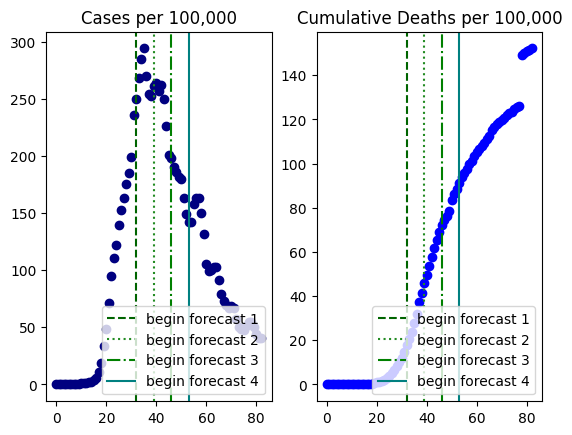

In [6]:
N = 19_340_000

fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.scatter(all_data4.index, all_data4.I, color="navy")
ax1.scatter(all_data4.index, 100000*(all_data4.I/N), color="navy")
ax1.axvline(x = 32, color = 'darkgreen', linestyle ="--", label = 'begin forecast 1')
ax1.axvline(x = 39, color = 'forestgreen', linestyle =":", label = 'begin forecast 2')
ax1.axvline(x = 46, color = 'green', linestyle ="-.", label = 'begin forecast 3')
ax1.axvline(x = 53, color = 'teal', label = 'begin forecast 4')
ax1.legend(loc='lower right')
# ax1.set_title("Cases")
ax1.set_title("Cases per 100,000")

# ax2.scatter(all_data4.index, all_data4.D, color="blue")
ax2.scatter(all_data4.index, 100000*(all_data4.D/N), color="blue")
ax2.axvline(x = 32, color = 'darkgreen', linestyle ="--", label = 'begin forecast 1')
ax2.axvline(x = 39, color = 'forestgreen', linestyle =":", label = 'begin forecast 2')
ax2.axvline(x = 46, color = 'green', linestyle ="-.", label = 'begin forecast 3')
ax2.axvline(x = 53, color = 'teal', label = 'begin forecast 4')
ax2.legend(loc='lower right')
# ax2.set_title("Cumulative Deaths")
ax2.set_title("Cumulative Deaths per 100,000")

# (1) Model 1

## (A) Load and sample from model prior distribution

In [20]:
num_samples=2
prior_samples = load_and_sample_petri_model(model2_location, num_samples, timepoints=timepoints1, method="dopri5",
                                            visual_options={"title": "Prior Distributions", "keep":".*_sol"}, 
                                            time_unit="days")
#display(prior_samples)

In [21]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), keep="I.*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [10]:
num_samples = 100
model_paths = [model2_location]
data_path = "../../notebook/ensemble_eval_sa/datasets/NYS_T1_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "I", "D": "D"}]

# Run the calibration and sampling
result1 = load_and_calibrate_and_sample_ensemble_model(
    model_paths,
    data_path,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=200,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "subset":".*_sol"}
)

# Save results
result1["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
result1["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

q_ensemble_data = cdc_reformatcsv(filename="../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", 
                                  solution_string_mapping={"I": "cases", "D": "deaths"}, 
                                  forecast_start_date="2020-04-03",
                                  location="New York State",
                                  drop_column_names=["timepoint_id", "number_days", "inc_cum", "output", "Forecast_Backcast"])
q_ensemble_data.to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble1_quantiles_Apr032020.csv")

# Plot results
schema = plots.trajectories(pd.DataFrame(result1["data"]), subset=".*_sol",
                            points=test_data.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 743.5768550932407
iteration 25: loss = 726.1113821566105


KeyboardInterrupt: 

In [10]:
num_samples = 100
model_paths = [model6_location]
data_path = "../../notebook/ensemble_eval_sa/datasets/NY_data1.csv"
weights = [1]
solution_mappings = [{"I": "infected", "D": "dead"}]

# Run the calibration and sampling
result2 = load_and_calibrate_and_sample_ensemble_model(
    model_paths,
    data_path,
    weights,
    solution_mappings,
    num_samples,
    timepoints,
    verbose=True,
    total_population=19340000,
    num_iterations=100,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "subset":".*_sol"}
)

# # Save results
# result2["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result2["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result2["data"]), subset=".*_sol",
                            points=test_data.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 715.3255967199802
iteration 25: loss = 675.6244948208332
iteration 50: loss = 638.4774799644947
iteration 75: loss = 642.9715199768543



In [ ]:
num_samples = 100
model_paths = [model7_location]
data_path = "../../notebook/ensemble_eval_sa/datasets/NY_data1.csv"
weights = [1]
solution_mappings = [{"I": "infected", "D": "dead"}]

# Run the calibration and sampling
result3 = load_and_calibrate_and_sample_ensemble_model(
    model_paths,
    data_path,
    weights,
    solution_mappings,
    num_samples,
    timepoints,
    verbose=True,
    total_population=19340000,
    num_iterations=50,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "subset":".*_sol"}
)

# # Save results
# result3["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result3["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result3["data"]), subset=".*_sol",
                            points=test_data.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

# Calibrate and sample an ensemble of multiple models

In [6]:
num_samples = 100
model_paths = [model2_location, model6_location, model7_location]
data_path = "../../notebook/ensemble_eval_sa/datasets/NY_data1.csv"
weights = [1/len(model_paths) for i in model_paths]
solution_mappings = [{"I": "I", "D": "D"},
                     {"I": "infected", "D": "dead"}, 
                     {"I": "infected", "D": "dead"}
                     ]

# Run the calibration and sampling
result4 = load_and_calibrate_and_sample_ensemble_model(
    model_paths,
    data_path,
    weights,
    solution_mappings,
    num_samples,
    timepoints,
    verbose=True,
    total_population=19340000,
    num_iterations=300,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "subset":".*_sol"}
)

# Save results
result4["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
result4["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

q_ensemble_data = cdc_reformatcsv(filename="../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", 
                                  solution_string_mapping={"I": "cases", "D": "deaths"}, 
                                  forecast_start_date="2020-04-02",
                                  location="New York State",
                                  drop_column_names=["timepoint_id", "number_days", "inc_cum", "output", "Forecast_Backcast"])
q_ensemble_data.to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_forecast_quantiles_Apr032020.csv")

# Plot results
schema = plots.trajectories(pd.DataFrame(result4["data"]), subset=".*_sol",
                            points=test_data.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 770.0332576930523
iteration 25: loss = 725.9352768361568
iteration 50: loss = 683.1315333545208
iteration 75: loss = 657.1365496814251
iteration 100: loss = 639.9664190709591
iteration 125: loss = 651.2667129933834
iteration 150: loss = 644.3884951770306
iteration 175: loss = 640.9029484689236
iteration 200: loss = 642.0637594163418
iteration 225: loss = 641.8007166087627
iteration 250: loss = 635.0509063899517
iteration 275: loss = 638.1880713403225



In [ ]:
num_samples = 100
model_paths = [model2_location, model7_location]
data_path = "../../notebook/ensemble_eval_sa/NY_data1.csv"
weights = [1/len(model_paths) for i in model_paths]
solution_mappings = [{"I": "I", "D": "D"},
                     {"I": "infected", "D": "dead"}
                     ]

# Run the calibration and sampling
result5 = load_and_calibrate_and_sample_ensemble_model(
    model_paths,
    data_path,
    weights,
    solution_mappings,
    num_samples,
    timepoints,
    verbose=True,
    total_population=19340000,
    num_iterations=500,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "subset":".*_sol"}
)

# Save results
# result5["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_two_results.csv", index=False)
# result5["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_two_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result4["data"]), subset=".*_sol",
                            points=test_data.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [ ]:
num_samples = 100
model_paths = [model2_location, model7_location]
data_path = "../../notebook/ensemble_eval_sa/NY_data1.csv"
weights = [1/len(model_paths) for i in model_paths]
solution_mappings = [{"I": "I", "D": "D"},
                     {"I": "infected", "D": "dead"}
                     ]

# Run the calibration and sampling
result4 = load_and_calibrate_and_sample_ensemble_model(
    model_paths,
    data_path,
    weights,
    solution_mappings,
    num_samples,
    timepoints,
    verbose=True,
    total_population=19340000,
    num_iterations=500,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "subset":".*_sol"}
)

# Save results
# result4["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result4["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result4["data"]), subset=".*_sol",
                            points=test_data.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [ ]:
num_samples = 100
model_paths = [model2_location, model6_location, model7_location]
data_path = "../../notebook/ensemble_eval_sa/NY_data1.csv"
weights = [1/len(model_paths) for i in model_paths]
solution_mappings = [{"I": "I", "D": "D"},
                     {"I": "infected", "D": "dead"}, 
                     {"I": "infected", "D": "dead"}
                     ]

# Run the calibration and sampling
result4 = load_and_calibrate_and_sample_ensemble_model(
    model_paths,
    data_path,
    weights,
    solution_mappings,
    num_samples,
    timepoints,
    verbose=True,
    total_population=19340000,
    num_iterations=500,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "subset":".*_sol"}
)

# Save results
# result4["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result4["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result4["data"]), subset=".*_sol",
                            points=test_data.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)